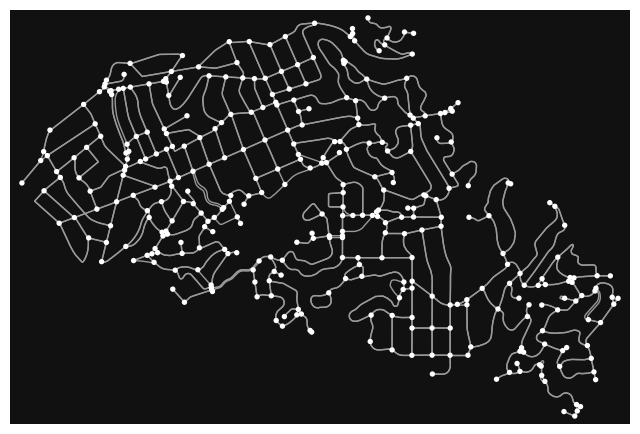

In [1]:
import networkx as nx
import osmnx as ox

ox.__version__


# download/model a street network for some city then visualize it
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")
fig, ax = ox.plot_graph(G)




In [2]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

print(D)


DiGraph with 353 nodes and 939 edges


In [3]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()
gdf_edges.head()

print(gdf_nodes.head())

                  y           x  street_count highway  \
osmid                                                   
53017091  37.826250 -122.247604             3     NaN   
53018397  37.824224 -122.247194             3     NaN   
53018399  37.824900 -122.246113             3     NaN   
53018402  37.825406 -122.245338             3     NaN   
53018404  37.825948 -122.244467             3     NaN   

                             geometry  
osmid                                  
53017091  POINT (-122.24760 37.82625)  
53018397  POINT (-122.24719 37.82422)  
53018399  POINT (-122.24611 37.82490)  
53018402  POINT (-122.24534 37.82541)  
53018404  POINT (-122.24447 37.82595)  


In [4]:


# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)



{'n': 353,
 'm': 948,
 'k_avg': 5.371104815864022,
 'edge_length_total': 112028.821,
 'edge_length_avg': 118.17386181434598,
 'streets_per_node_avg': 2.951841359773371,
 'streets_per_node_counts': {0: 0, 1: 34, 2: 0, 3: 270, 4: 47, 5: 2},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09631728045325778,
  2: 0.0,
  3: 0.7648725212464589,
  4: 0.13314447592067988,
  5: 0.0056657223796034},
 'intersection_count': 319,
 'street_length_total': 58076.252,
 'street_segment_count': 497,
 'street_length_avg': 116.85362575452716,
 'circuity_avg': 1.1111605002201332,
 'self_loop_proportion': 0.006036217303822937,
 'clean_intersection_count': 267,
 'node_density_km': 84.06195830904933,
 'intersection_density_km': 75.96533909514656,
 'edge_density_km': 26678.079547631583,
 'street_density_km': 13830.038171019385,
 'clean_intersection_density_km': 63.58227441505997}

In [5]:
import requests

def get_elevation_open_elevation(lat, lon):
    base_url = "https://api.open-elevation.com/api/v1/lookup"
    params = {
        "locations": f"{lat},{lon}",
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    if "results" in data and data["results"]:
        elevation = data["results"][0]["elevation"]
        return elevation
    else:
        return None

# Example usage
latitude = 37.7749  # Replace with the desired latitude
longitude = -122.4194  # Replace with the desired longitude

elevation = get_elevation_open_elevation(latitude, longitude)
print(f"Elevation: {elevation} meters")


# print(G.nodes(data=True))
print(G)

# Add elevation data to nodes
for node, data in G.nodes(data=True):
    elevation = get_elevation_open_elevation(data['y'], data['x'])
    data['elevation'] = elevation

print("elevation added")

# G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
G = ox.elevation.add_edge_grades(G)
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
print("done")


Elevation: 16.0 meters
MultiDiGraph with 353 nodes and 948 edges


KeyboardInterrupt: 

test


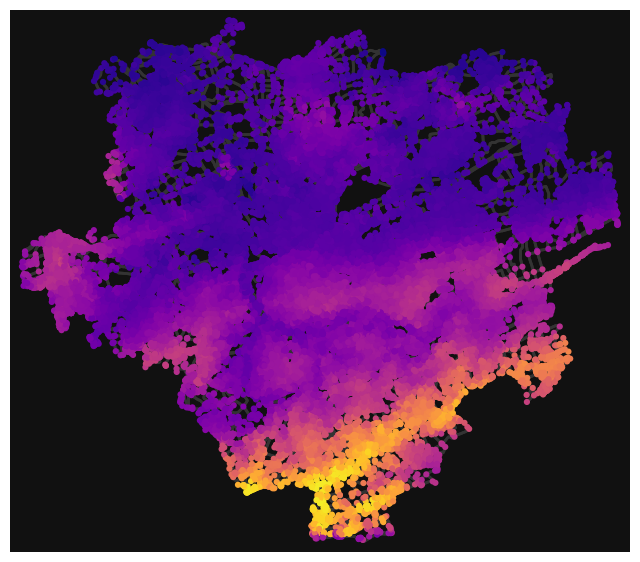

In [2]:
import osmnx as ox
import requests
import pandas as pd
import requests
import networkx as nx
from joblib import Memory
from osmnx import simplification

location = './cache'
memory = Memory(location, verbose=0)

def get_elevation_open_elevation(lat, lon):
    base_url = "http://localhost:443/api/v1/lookup?"
    params = {
        "locations": f"{lat},{lon}",
    }

    response = requests.get(base_url, params=params)
    data = response.json() if response is not None and response.content else None
    if 'results' in data and data['results']:
        elevation = data['results'][0]['elevation']
    return elevation

    # if 'highway' in data.tags:
    #     if data.tags['highway'] in ['motorway', 'motorway_link', 'trunk', 'trunk_link']:
    #         return False  # Exclude highways where walking or biking is not allowed
    # elif 'railway' in data.tags:
    #     return False  # Exclude railways (subways/trains)
    # elif 'amenity' in data.tags and data.tags['amenity'] == 'parking':
    #     return False  # Exclude parking lots
    # elif 'foot' in data.tags and data.tags['foot'] == 'no':
    #     return False  # Exclude roads where walking is not allowed
    # elif 'bicycle' in data.tags and data.tags['bicycle'] == 'no':
    #     return False  # Exclude roads where biking is not allowed
    # return True

def compute_graph_with_elevation():
    custom_filter ='["bicycle"!~"no"]["foot"!~"no"]["building"!~"."]["amenity"!~"parking"]["railway"!~"."]'
    
    
    # Specify the place name for North Rhine-Westphalia, Germany
    place_name = "Dortmund, North-Rhine Westphalia, Germany"
    print("start")
    
    # Create the graph for NRW
    G = ox.graph_from_place(place_name, network_type='all')
    # G = simplification.simplify_graph(G)
    # G = nx.DiGraph(G_multi)
    # print(G_multi)
    # print(G)
    # G = ox.graph_from_place(place_name, network_type='all', custom_filter = custom_filter)
    print(G)
    
    # Add elevation data to nodes
    for node, data in G.nodes(data=True):
    
        elevation = get_elevation_open_elevation(data['y'], data['x'])
        # data['elevation'] = elevation  
        if elevation is not None:
            data['elevation'] = elevation
        else:
            print(f"Failed to retrieve elevation data for node {node}")
    
    print("elevation")
    
    # source_target_nodes = set()
    # for u, v in G.edges():
    #     source_target_nodes.add(u)
    #     source_target_nodes.add(v)
    
    # # Create a copy of the graph with only nodes that are source or target nodes
    # G_filtered = G.subgraph(source_target_nodes).copy()
    # print("filtered")
    # print(G_filtered)

    
    # Convert the graph data to pandas DataFrames
    df_nodes, df_edges = ox.graph_to_gdfs(G)
    print("convert")
    print(df_nodes)
    
    
    # Save the DataFrames to CSV files
    df_nodes.to_csv('nodes_nrw.csv', index=False)
    df_edges.to_csv('edges_nrw.csv', index=False)
    
    
    G = ox.elevation.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
    
    print("done")
    return G

compute_graph_with_elevation = memory.cache(compute_graph_with_elevation)
print("test")
G = compute_graph_with_elevation()
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")

In [5]:
from shapely.geometry import LineString
import pyodbc
import hashlib
import uuid

# Establish connection to SQL Server
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=localhost\\SQLEXPRESS;'
                      'Database=GridDataDB;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()


def create_table_node():
    cursor.execute('''
		CREATE TABLE Node (
            Id UNIQUEIDENTIFIER PRIMARY KEY,
            GeographyValues GEOGRAPHY,
            SurroundingsTags TEXT,
            Elevation INT
            )
                ''')

def create_table_edge():
    cursor.execute('''
		CREATE TABLE Edge (
            Id UNIQUEIDENTIFIER,
            ShoelaceForward DECIMAL(18, 0),
            ShoelaceBackward DECIMAL(18, 0),
            Tags TEXT,
            GeoLocations GEOGRAPHY,
            SourceNodeId UNIQUEIDENTIFIER FOREIGN KEY REFERENCES Edge(Id),
            TargetNodeId UNIQUEIDENTIFIER FOREIGN KEY REFERENCES Edge(Id),
            Reversed BIT NULL,
            Cost DECIMAL(18, 0),
            OneWay BIT NULL    
            PRIMARY KEY (Id, SourceNodeId, TargetNodeId)
			)
               ''')

def create_table_incident_edges():
     cursor.execute('''
        CREATE TABLE IncidentEdges (
            node_id UNIQUEIDENTIFIER,
            edge_id UNIQUEIDENTIFIER,
            NodeId UNIQUEIDENTIFIER FOREIGN KEY REFERENCES Nodes(Id),
            EdgeId UNIQUEIDENTIFIER FOREIGN KEY REFERENCES Edges(Id),
            PRIMARY KEY (NodeId, EdgeId)
        )
    ''')

def check_id_exists(cursor, node_id, table_name):
    cursor.execute("SELECT COUNT(*) FROM " + table_name + " WHERE Id = ?", node_id)
    count = cursor.fetchone()[0]
    return count > 0

def check_ids_exist(cursor, id1, id2, table_name):
    cursor.execute("SELECT COUNT(*) FROM " + table_name + " WHERE NodeId = ? AND EdgeId = ?", (id1, id2))
    count = cursor.fetchone()[0]
    return count > 0

def check_edge_ids_exists(cursor, source_node_id, target_node_id, edge_id, table_name):
    cursor.execute("SELECT COUNT(*) FROM " + table_name + " WHERE Id = ? AND SourceNodeId = ? AND TargetNodeId = ?", edge_id,source_node_id,target_node_id )
    count = cursor.fetchone()[0]
    return count > 0

def generate_id(osmid_tuple):
    # print(osmid_tuple)
    if isinstance(osmid_tuple, int):
        # int_bytes = osmid_tuple.to_bytes((osmid_tuple.bit_length() + 7) // 8, byteorder='big', signed=False)
        # sha256_digest = hashlib.sha256(int_bytes).digest()
        # uuid_bytes = sha256_digest[:16]
        return uuid.UUID(int=osmid_tuple)
    else:
        osmid_str = ','.join(str(osmid) for osmid in sorted(osmid_tuple)).encode()
        sha256_digest = hashlib.sha256(osmid_str).digest()
        edge_uuid = uuid.UUID(bytes=sha256_digest[:16])  # Convert the first 16 bytes to UUID
        return edge_uuid

# Sorting key function to handle both single number and list of numbers
def sorting_key(edge):
    osmid = edge[2].get('osmid')
    if isinstance(osmid, list):
        # If osmid is a list, return the minimum value in the list
        return min(osmid)
    else:
        # If osmid is a single number, return the number itself
        return osmid

def swap_coordinates_order(coordinates_list):
    swapped_coordinates = []
    for lon, lat in coordinates_list:
        swapped_coordinates.append((lat, lon))
    return swapped_coordinates
    
# Query to get all tables
tables = cursor.execute("SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'")

# Fetch all table names
table_names = [table[0] for table in tables.fetchall()]

# Print the list of table names
if table_names == []:
    print('Table not found!')
    create_table_node()
    create_table_edge()
    create_table_incident_edges()
    print("create all")
else:
    if "Edge" not in table_names:
        create_table_edge()
        print("edge")
    if "Node" not in table_names:
        crate_table_node()
        print("node")
    if "IncidentEdges" not in table_names:
        create_table_incident_edges()
        print("incident edges")
    

print("done")

nodes = list(G.nodes(data=True))
edges = list(G.edges(data=True))


# Insert node data into the Nodes table
cursor = conn.cursor()
for node  in nodes:
    node_id = generate_id(node[0])
    if 'natural' in node:
        print("natural")
    if 'landuse' in node:
        print("landuse")
    # nature_tags = data.get('nature', [])
    # landuse_tags = data.get('landuse', [])
    if not check_id_exists(cursor, node_id, "Node"):
        point = f"POINT({node[1]['x']} {node[1]['y']})"
        if(node[1]['x'] > 90 or node[1]['x'] < -90 or node[1]['y'] > 90 or node[1]['y'] < -90):
            print(point)
        cursor.execute('''
            INSERT INTO Node (Id, GeographyValues, Elevation)
            VALUES (?, geography::STGeomFromText(?, 4326), ?)
        ''', (node_id, point, node[1].get('elevation', None)))

print("commit nodes")
conn.commit()


# Insert edge data into the Edges table
for source_node_id, target_node_id, edge_attrs in sorted(edges, key=sorting_key):
    node_not_inserted = False
    edge_id = generate_id(edge_attrs.get('osmid',None))

    
    highway_tags = edge_attrs.get('highway', [])
    # print(source_node_id in source_target_nodes and target_node_id in source_target_nodes)
    source_node_id = generate_id(source_node_id)
    target_node_id = generate_id(target_node_id)
    # print("Edge {} from node {} to node {}".format(edge_id, source_node_id, target_node_id))
    # if edge_attrs.get('geometry') is not None:
    #     geolocations = edge_attrs.get('geometry')
    #     if isinstance(geolocations, str):
    #         print(geolocations)
    #     else:
    #         print(geolocations.wkt)

    
    if not check_edge_ids_exists(cursor, source_node_id,target_node_id,  edge_id, "Edge"):
        # source_node_id = generate_id(source_node_id)
        # target_node_id = generate_id(target_node_id)
        cursor.execute('''
            INSERT INTO Edge (Id, SourceNodeId, TargetNodeId, Cost, Tags, Oneway, Reversed)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (
        edge_id,
        source_node_id,
        target_node_id,
        edge_attrs.get('length', None),
        ', '.join(highway_tags) 
          if (isinstance(highway_tags, list) and 
                    all(isinstance(item, str) and 
                        len(item) > 1 for item in highway_tags)) 
              else highway_tags,
        # ', '.join(nature_tags + landuse_tags) 
        #     if ((isinstance(nature_tags, list) and 
        #              all(isinstance(item, str) and len(item) > 1 for item in nature_tags)) or 
        #         (isinstance(landuse_tags, list) and 
        #              all(isinstance(item, str) and len(item) > 1 for item in landuse_tags))
        #     ) else None

        1 if edge_attrs.get('oneway', None) else 0, 
        1 if edge_attrs.get('reversed', None) else 0
        ))
    
    if edge_attrs.get('geometry') is not None:
        geolocations = edge_attrs.get('geometry')
        if geolocations:
            # print(geolocations)
            swap_geolocations = LineString(swap_coordinates_order(list(geolocations.coords)))
            # print(swap_geolocations)
            
        if isinstance(swap_geolocations, str):
            # print("string")
            # Convert WKT string to binary using STGeomFromText
            cursor.execute('''
                UPDATE Edge
                SET GeoLocations = geography::STGeomFromText(?, 4326)
                WHERE Id = ?
                AND SourceNodeId = ? 
                AND TargetNodeId = ?
            ''', (swap_geolocations, edge_id,source_node_id,target_node_id))
        else:
            # print("wkt")
            # Convert WKT representation of geometry to binary using STGeomFromText
            cursor.execute('''
                UPDATE Edge
                SET GeoLocations = geography::STGeomFromText(?, 4326)
                WHERE Id = ?
                AND SourceNodeId = ? 
                AND TargetNodeId = ?
            ''', (swap_geolocations.wkt, edge_id,source_node_id,target_node_id))

    
    if not check_ids_exist(cursor, source_node_id, edge_id, "IncidentEdges"):
        cursor.execute('''
            INSERT INTO IncidentEdges (NodeId, edgeId)
            VALUES (?, ?)
        ''', (source_node_id, edge_id))
    else:
        if node_not_inserted:
            print("error")
    if not check_ids_exist(cursor, target_node_id, edge_id, "IncidentEdges"):
        cursor.execute('''
            INSERT INTO IncidentEdges (NodeId, edgeId)
            VALUES (?, ?)
        ''', (target_node_id, edge_id))
    # else:
        # if edge_attrs.get('geometry') is not None:
        #     cursor.execute('''
        #             UPDATE Edge
        #             SET SourceNodeId = ?, TargetNodeId = ?
        #             WHERE Id = ?
        #         ''', (source_node_id, target_node_id, edge_id))

conn.commit()
print("commit edges")

# Close the cursor and connection
cursor.close()
conn.close()
print("all done")


done
commit nodes
commit edges
all done


In [2]:
import osmnx as ox
import warnings
import uuid
import pyodbc
import hashlib
import pandas as pd

# Suppress all DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# G = ox.graph_from_place('Dortmund, North Rhine Westphalia, Germany', network_type='all')
landuse_features = ox.features.features_from_place('Dortmund, North Rhine Westphalia, Germany', tags={"landuse": True})

# Fetch features based on natural
natural_features = ox.features.features_from_place('Dortmund, North Rhine Westphalia, Germany', tags={"natural": True})

# Concatenate the two DataFrames
all_features = pd.concat([landuse_features, natural_features], ignore_index=True)

# Now you can work with the combined DataFrame 'all_features'
# print(all_features.head())
# print(natural_features.head)
# print(natural_features.columns)

node_values_dict = {}

def generate_id(osmid_tuple):
    # print(osmid_tuple)
    if isinstance(osmid_tuple, int):
        return uuid.UUID(int=osmid_tuple)
    else:
        osmid_str = ','.join(str(osmid) for osmid in sorted(osmid_tuple)).encode()
        sha256_digest = hashlib.sha256(osmid_str).digest()
        edge_uuid = uuid.UUID(bytes=sha256_digest[:16])  # Convert the first 16 bytes to UUID
        return edge_uuid


# currently sets surroundings for nodes --> change to edges
# no edge values stored (only node ids) --> 

# Iterate over landuse features
for idx, area in landuse_features.iterrows():
    # Extract values
    nodes_value = area['nodes']
    landuse_value = area['landuse'] if 'landuse' in area else None
    
    if isinstance(nodes_value, float):
        node_id = generate_id(node)
        if node_id not in node_values_dict:
            node_values_dict[node_id] = {'landuse': set(), 'natural': set()}
        if landuse_value and landuse_value not in node_values_dict[node_id]['landuse']:
            node_values_dict[node_id]['landuse'].add(landuse_value)
    else:
    # Iterate over nodes and update the dictionary
        for node in nodes_value:
            node_id = generate_id(node)
            if node_id not in node_values_dict:
                node_values_dict[node_id] = {'landuse': set(), 'natural': set()}
            if landuse_value and landuse_value not in node_values_dict[node_id]['landuse']:
                node_values_dict[node_id]['landuse'].add(landuse_value)

# Iterate over natural features
for idx, area in natural_features.iterrows():
    # Extract values
    nodes_value = area['nodes']
    natural_value = area['natural'] if 'natural' in area else None

    if isinstance(nodes_value, float):
        node_id = generate_id(node)
        if node_id not in node_values_dict:
            node_values_dict[node_id] = {'landuse': set(), 'natural': set()}
        if natural_value and natural_value not in node_values_dict[node_id]['natural']:
            node_values_dict[node_id]['natural'].add(natural_value)
    else:
        # Iterate over nodes and update the dictionary
        for node in nodes_value:
            node_id = generate_id(node)
            if node_id not in node_values_dict:
                node_values_dict[node_id] = {'landuse': set(), 'natural': set()}
            if natural_value and natural_value not in node_values_dict[node_id]['natural']:
                node_values_dict[node_id]['natural'].add(natural_value)



# Establish connection to SQL Server
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=localhost\\SQLEXPRESS;'
                      'Database=GridDataDB;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()


for node_id, values in node_values_dict.items():
                
    landuse_string = ", ".join(values['landuse'])
    natural_string = ", ".join(values['natural'])
    cursor.execute('''
            UPDATE Node
            SET Surroundings = ?
            WHERE Id = ?
        ''', (landuse_string + ";" + natural_string, node_id))

conn.commit()
print("commit surroundings")

# Close the cursor and connection
cursor.close()
conn.close()

print("done")

commit surroundings
done


In [1]:
# pip install --upgrade geopandas pandas

In [19]:

import pyodbc
import hashlib
import uuid

# Establish connection to SQL Server
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=localhost\\SQLEXPRESS;'
                      'Database=test;'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()


def create_table_node():
    cursor.execute('''
		CREATE TABLE Node (
            Id BIGINT PRIMARY KEY,
            GeographyValues GEOGRAPHY,
            Elevation DECIMAL(18, 0)
            )
                ''')

def create_table_edge():
    cursor.execute('''
		CREATE TABLE Edge (
            Id UNIQUEIDENTIFIER PRIMARY KEY,
            ShoelaceForward DECIMAL(18, 0),
            ShoelaceBackward DECIMAL(18, 0),
            Tags TEXT,
            GeoLocations GEOGRAPHY,
            SourceNodeId BIGINT FOREIGN KEY REFERENCES Node(Id),
            TargetNodeId BIGINT FOREIGN KEY REFERENCES Node(Id),
            Reversed BIT NULL,
            Cost DECIMAL(18, 0),
            OneWay BIT NULL            
			)
               ''')

def create_table_incident_edges():
     cursor.execute('''
        CREATE TABLE IncidentEdges (
            node_id BIGINT,
            edge_id BIGINT,
            NodeId BIGINT FOREIGN KEY REFERENCES Node(Id),
            EdgeId UNIQUEIDENTIFIER FOREIGN KEY REFERENCES Edge(Id),
            PRIMARY KEY (NodeId, EdgeId)
        )
    ''')

def check_id_exists(cursor, node_id, table_name):
    cursor.execute("SELECT COUNT(*) FROM " + table_name + " WHERE Id = ?", node_id)
    count = cursor.fetchone()[0]
    return count > 0

def check_ids_exist(cursor, id1, id2, table_name):
    cursor.execute("SELECT COUNT(*) FROM " + table_name + " WHERE NodeId = ? AND EdgeId = ?", (id1, id2))
    count = cursor.fetchone()[0]
    return count > 0


def generate_id(osmid_tuple):
    print(osmid_tuple)
    if isinstance(osmid_tuple, int):
        print(uuid.UUID(int=osmid_tuple))
        return uuid.UUID(int=osmid_tuple)
    else:
        osmid_str = ','.join(str(osmid) for osmid in sorted(osmid_tuple)).encode()
        sha256_digest = hashlib.sha256(osmid_str).digest()
        edge_uuid = uuid.UUID(bytes=sha256_digest[:16])  # Convert the first 16 bytes to UUID
        print(edge_uuid)
        return edge_uuid

# Sorting key function to handle both single number and list of numbers
def sorting_key(edge):
    osmid = edge[2].get('osmid')
    if isinstance(osmid, list):
        # If osmid is a list, return the minimum value in the list
        return min(osmid)
    else:
        # If osmid is a single number, return the number itself
        return osmid


# Query to get all tables
tables = cursor.execute("SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'")

# Fetch all table names
table_names = [table[0] for table in tables.fetchall()]

# Print the list of table names
if table_names == []:
    print('Table not found!')
    create_table_node()
    create_table_edge()
    create_table_incident_edges()
    print("create all")
else:
    if "Edge" not in table_names:
        create_table_edge()
        print("edge")
    if "Node" not in table_names:
        crate_table_node()
        print("node")
    if "IncidentEdges" not in table_names:
        create_table_incident_edges()
        print("incident edges")
    

print("done")

nodes = list(G.nodes(data=True))
edges = list(G.edges(data=True))


# Insert node data into the Nodes table
cursor = conn.cursor()
for node in nodes:
    node_id = node[0]
    if not check_id_exists(cursor, node_id, "Node"):
        point = f"POINT({node[1]['x']} {node[1]['y']})"
        if(node[1]['x'] > 90 or node[1]['x'] < -90 or node[1]['y'] > 90 or node[1]['y'] < -90):
            print(point)
        cursor.execute('''
            INSERT INTO Node (Id, GeographyValues, Elevation)
            VALUES (?, geography::STGeomFromText(?, 4326), ?)
        ''', (node_id, point, node[1].get('elevation', None)))

print("commit nodes")
conn.commit()


# Insert edge data into the Edges table
for source_node_id, target_node_id, edge_attrs in sorted(edges, key=sorting_key):
    node_not_inserted = False    
    highway_tags = edge_attrs.get('highway', [])
    edge_id = uuid.uuid4()

    
    cursor.execute('''
        INSERT INTO Edge (Id, SourceNodeId, TargetNodeId, Cost, Tags, Oneway, Reversed)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    ''', (
    edge_id,
    source_node_id,
    target_node_id,
    edge_attrs.get('length', None),
    ', '.join(highway_tags) 
      if (isinstance(highway_tags, list) and 
                all(isinstance(item, str) and 
                    len(item) > 1 for item in highway_tags)) 
          else highway_tags,
    1 if edge_attrs.get('oneway', None) else 0, 
    1 if edge_attrs.get('reversed', None) else 0
    ))

    if edge_attrs.get('geometry') is not None:
        geolocations = edge_attrs.get('geometry')
        if isinstance(geolocations, str):
            # Convert WKT string to binary using STGeomFromText
            cursor.execute('''
                UPDATE Edge
                SET GeoLocations = geography::STGeomFromText(?, 4326)
                WHERE Id = ?
            ''', (geolocations, edge_id))
        else:
            # Convert WKT representation of geometry to binary using STGeomFromText
            cursor.execute('''
                UPDATE Edge
                SET GeoLocations = geography::STGeomFromText(?, 4326)
                WHERE Id = ?
            ''', (geolocations.wkt, edge_id))


    if not check_ids_exist(cursor, source_node_id, edge_id, "IncidentEdges"):
        cursor.execute('''
            INSERT INTO IncidentEdges (NodeId, edgeId)
            VALUES (?, ?)
        ''', (source_node_id, edge_id))
    else:
        if node_not_inserted:
            print("error")
    if not check_ids_exist(cursor, target_node_id, edge_id, "IncidentEdges"):
        cursor.execute('''
            INSERT INTO IncidentEdges (NodeId, edgeId)
            VALUES (?, ?)
        ''', (target_node_id, edge_id))

conn.commit()
print("commit edges")

# Close the cursor and connection
cursor.close()
conn.close()
print("all done")

done
commit nodes
commit edges
all done
